In [2]:
import os
import sys
import boto

import numpy as np
import pandas as pd

import re
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
S3_BUCKET_NAME = 'ai-dev'

# Using sample Kaggle.com titanic dataset for classification
csv_file = 'sample_data/titanic_train.csv'
s3_file = 's3://{}/{}'.format(S3_BUCKET_NAME, csv_file)
data = pd.read_csv(s3_file)

In [5]:
data.shape

(891, 12)

In [6]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


------------------------
## Explore and Transform the data


------------------------

----------------
### Cabin Class

In [8]:
print(data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


### Sex

In [9]:
print(data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


### Family information - Siblings and Parents

In [10]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
print(data[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


In [11]:
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1
print(data[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


### Embarked Passengers

In [12]:
data['Embarked'] = data['Embarked'].fillna('S')
print(data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


### Fare

In [13]:
data['Fare'] = data['Fare'].fillna(data['Fare'].median())
data['CategoricalFare'] = pd.qcut(data['Fare'], 4)
print(data[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


### Age

In [15]:
age_avg = data['Age'].mean()
age_std = data['Age'].std()

# Impute missage ages by taking random sample within 1 stdeviation from the mean
sample_lower_bound = age_avg - age_std
sample_upper_bound = age_avg + age_std
def get_impute_age(age):
    if np.isnan(age):
        return int(np.random.randint(sample_lower_bound, sample_upper_bound))
    return int(age)

data['Age'] = data['Age'].apply(get_impute_age)

data['CategoricalAge'] = pd.cut(data['Age'], 5)

print(data[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.537037
1   (16.0, 32.0]  0.365256
2   (32.0, 48.0]  0.350394
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


### Name/title

In [16]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


data['Title'] = data['Name'].apply(get_title)

print(pd.crosstab(data['Title'], data['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [17]:
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 
                                       'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

print(data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


## Map the data to normalized features

In [18]:
# Mapping Sex
data['Sex'] = data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Mapping titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
data['Title'] = data['Title'].map(title_mapping)
data['Title'] = data['Title'].fillna(0)

# Mapping Embarked
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

# Mapping Fare
data.loc[data['Fare'] <= 7.91, 'Fare'] = 0
data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
data.loc[data['Fare'] > 31, 'Fare'] = 3
data['Fare'] = data['Fare'].astype(int)

# Mapping Age
data.loc[data['Age'] <= 16, 'Age'] = 0
data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
data.loc[data['Age'] > 64, 'Age'] = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'FamilySize']
data = data.drop(drop_elements, axis=1)
data = data.drop(['CategoricalAge', 'CategoricalFare'], axis=1)

print(data.head(10))

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    1    1     0         0        0      1
1         1       1    0    2     3         1        0      3
2         1       3    0    1     1         0        1      2
3         1       1    0    2     3         0        0      3
4         0       3    1    2     1         0        1      1
5         0       3    1    1     1         2        1      1
6         0       1    1    3     3         0        1      1
7         0       3    1    0     2         0        0      4
8         1       3    0    1     1         0        0      3
9         1       2    0    0     2         1        0      3


## Build Models

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# fix random seed for reproducibility
np.random.seed(7)

In [19]:
# split into input (X) and output (Y) variables
X = data.values[0::, 1::]
Y = data.values[0::, 0]

In [25]:
X.shape

(891, 7)

In [41]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=7, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# # create model
# model = Sequential()
# model.add(Dense(21, input_dim=7, activation='relu'))
# model.add(Dense(21, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(21, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='sigmoid'))

In [42]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
# Fit the model
history = model.fit(X, Y, epochs=50, batch_size=10)

Epoch 1/50
891/891 [==============================] - 1s 995us/step - loss: 0.6198 - acc: 0.6846
Epoch 2/50
891/891 [==============================] - 0s 191us/step - loss: 0.5633 - acc: 0.7273
Epoch 3/50
891/891 [==============================] - 0s 191us/step - loss: 0.5296 - acc: 0.7508
Epoch 4/50
891/891 [==============================] - 0s 186us/step - loss: 0.5102 - acc: 0.7531
Epoch 5/50
891/891 [==============================] - 0s 193us/step - loss: 0.4946 - acc: 0.7587
Epoch 6/50
891/891 [==============================] - 0s 187us/step - loss: 0.4852 - acc: 0.7845
Epoch 7/50
891/891 [==============================] - 0s 187us/step - loss: 0.4745 - acc: 0.7935
Epoch 8/50
891/891 [==============================] - 0s 185us/step - loss: 0.4676 - acc: 0.7946
Epoch 9/50
891/891 [==============================] - 0s 185us/step - loss: 0.4600 - acc: 0.7957
Epoch 10/50
891/891 [==============================] - 0s 191us/step - loss: 0.4563 - acc: 0.7980
Epoch 11/50
891/891 [========

In [44]:
# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

891/891 [==============================] - 0s 130us/step

acc: 81.93%


In [45]:
# calculate predictions
predictions = model.predict(X)
# round predictions
rounded = [x[0] for x in predictions]
print(rounded[:10])

[0.07805262, 0.97052526, 0.48379904, 0.96825165, 0.05009806, 0.15101163, 0.26474565, 0.26858476, 0.4970544, 0.9594095]


(array([307., 116.,  74.,  73.,  65.,  48.,  10.,  33.,  65., 100.]),
 array([0.02285942, 0.11852974, 0.21420006, 0.3098704 , 0.4055407 ,
        0.50121105, 0.59688133, 0.6925517 , 0.788222  , 0.8838923 ,
        0.97956264], dtype=float32),
 <a list of 10 Patch objects>)

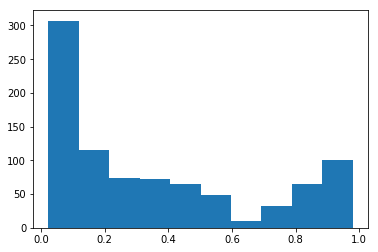

In [46]:
plt.hist(rounded)

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [56]:
# Will sample a few different classifiers
classifiers = [
    KNeighborsClassifier(3),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()
]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

In [55]:
X = data.values[0::, 1::]
y = data.values[0::, 0]

acc_dict = {}

In [57]:
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc


In [58]:
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

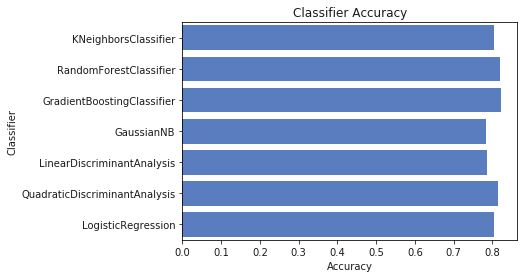

In [59]:
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [60]:
model = GradientBoostingClassifier()
model.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Use Simple Sample Test Data

In [62]:
print(X[0], y[0])

[3. 1. 1. 0. 0. 0. 1.] 0.0


In [65]:
model.predict_proba([X[0]])

array([[0.90255546, 0.09744454]])

### Save the Model for Future Use

Couldnt exactly figure out if there is a better way to do this or not?

In [ ]:
import boto3
from io import BytesIO
import pickle
from sklearn.externals import joblib

In [ ]:
model_path = 'sample_data/titanic_model.pkl'

pickle_buffer = BytesIO()
s3_resource = boto3.resource('s3')

joblib.dump(model, pickle_buffer)
# pickle.dump(model, pickle_buffer)  ## can use pickle too 
s3_resource.Object(S3_BUCKET_NAME, model_path).put(Body=pickle_buffer.getvalue())

### Sample for hosting the model 

In [ ]:
# https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb
# https://medium.com/@patrickmichelberger/how-to-deploy-a-serverless-machine-learning-microservice-with-aws-lambda-aws-api-gateway-and-d5b8cbead846